# item-based collaborative filtering

In [ ]:
from google.colab import drive
from google.colab import files
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
title_df=pd.read_csv(r"/content/drive/MyDrive/dataset/new_df.csv")
rating=pd.read_csv('/content/drive/MyDrive/MRS/ratings_small.csv')

In [ ]:
title_df.rename(columns={'id': 'movieId'}, inplace=True)


In [ ]:
title_df.columns

Index(['movieId', 'imdb_id', 'title', 'cast', 'director', 'genres', 'keywords',
       'overview', 'tagline', 'popularity', 'release_year', 'vote_average',
       'vote_count', 'weighted_rating'],
      dtype='object')

In [ ]:
title_df=title_df[['movieId','title','genres']]

In [ ]:
title_df.head( )

,movieId,title,genres
0,862,Toy Story,"['Animation', 'Comedy', 'Family']"
1,8844,Jumanji,"['Adventure', 'Fantasy', 'Family']"
2,15602,Grumpier Old Men,"['Romance', 'Comedy']"
3,31357,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']"
4,11862,Father of the Bride Part II,['Comedy']


In [ ]:
title_df.shape

(45366, 3)

In [ ]:
title_df.duplicated().sum()

21

In [ ]:
title_df.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [ ]:
title_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45366 entries, 0 to 45365
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  45366 non-null  int64 
 1   title    45366 non-null  object
 2   genres   45366 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [ ]:
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
rating.duplicated().sum()

0

In [ ]:
rating.shape

(100004, 4)

In [ ]:
df_rating = rating.pivot(index='movieId',columns='userId',values='rating')
df_rating.head()


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_rating.fillna(0,inplace=True)

In [ ]:
df_rating.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


threshold for data

To qualify a movie, a minimum of 10 users should have voted a movie.

To qualify a user, a minimum of 50 movies should have voted by the user.

In [ ]:
user_voted = rating.groupby('movieId')['rating'].agg('count')
movies_voted = rating.groupby('userId')['rating'].agg('count')

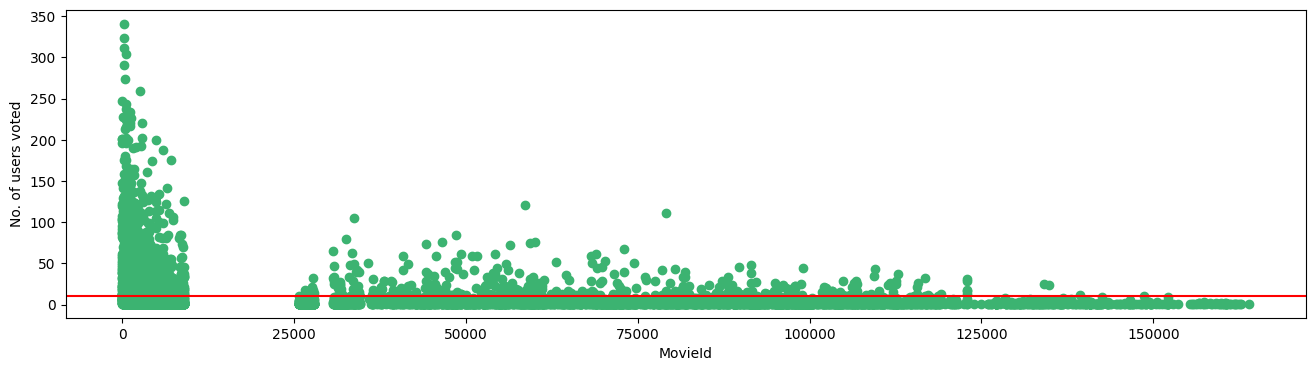

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
#rating['rating'].plot(kind='hist')
plt.scatter(user_voted.index,user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [ ]:
df_rating=df_rating.loc[user_voted[user_voted>10].index,:]

In [ ]:
df_rating.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


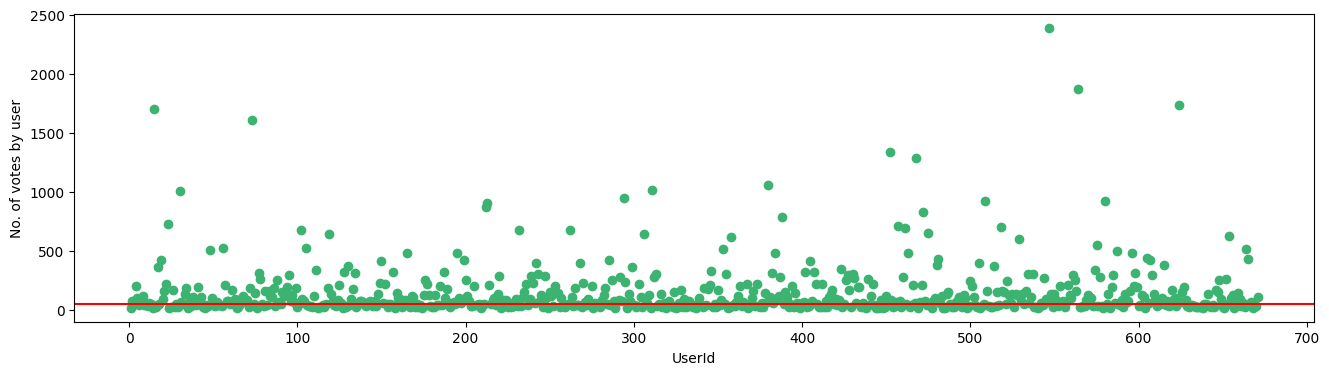

In [ ]:
#visualize the number of votes by each user with our threshold of 50.
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(movies_voted.index,movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [ ]:
df_rating=df_rating.loc[:,movies_voted[movies_voted > 50].index]

In [ ]:
df_rating.head()

userId,2,3,4,5,7,8,12,13,15,17,...,655,656,658,659,660,662,664,665,667,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,2.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,3.5,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,4.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0
3,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [ ]:
#df_rating.set_index("userId", inplace=True)

df_rating.head()


userId,2,3,4,5,7,8,12,13,15,17,...,655,656,658,659,660,662,664,665,667,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,2.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,3.5,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,4.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0
3,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [ ]:
print(df_rating)
print(df_rating.shape)


userId   2    3    4    5    7    8    12   13   15   17   ...  655  656  658  \
movieId                                                    ...                  
1        0.0  0.0  0.0  0.0  3.0  0.0  0.0  5.0  2.0  0.0  ...  0.0  0.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  ...  4.0  0.0  0.0   
3        0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.5  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
122900   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  0.0  ...  0.0  0.0  0.0   
122904   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
134130   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.5  0.0  ...  0.0  0.0  0.0   
134853   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
139385   0.0  0.0  0.0  0.0 

In [ ]:
from scipy.sparse import csr_matrix

# Convert final_dataset to a CSR matrix

ratings_matrix= csr_matrix(df_rating.values)
df_rating.reset_index(inplace=True)

In [ ]:
df_rating = rating.pivot(index='movieId',columns='userId',values='rating')
df_rating.fillna(0,inplace=True)

In [ ]:
import pandas as pd

# Converting the DataFrame to a numpy array
#ratings_matrix = df_rating.to_numpy()
#print(ratings_matrix)

[[0. 0. 0. ... 0. 4. 5.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(ratings_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [ ]:
# Converting the DataFrame to a numpy array
ratings_matrix = df_rating.to_numpy() 
print(ratings_matrix)


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
# Assuming top_recommendations contains movie indices
# Create a mapping of movie indices to movie IDs
movie_indices_to_id = dict(enumerate(new_df3['id']))

# Update the recommend_movies() function to return movie indices instead of movie IDs
def recommend_movies(self, user_id, top_n=5):
    user_ratings = self.ratings_matrix[user_id, :]
    pred_ratings = self.predict(user_id)

    # Set already rated movies predicted ratings to a very low value
    pred_ratings[user_ratings.nonzero()] = -np.inf

    # Get indices of top N movies based on predicted ratings
    top_movie_indices = np.argsort(pred_ratings)[::-1][:top_n]

    return top_movie_indices

class CollaborativeFilteringRecommender:
    def __init__(self, k=5):
        self.k = k  # No.of similar users to consider
        self.user_similarity = None
        self.ratings_matrix = None

    def fit(self, ratings_matrix):
        self.ratings_matrix = ratings_matrix
        self.user_similarity = cosine_similarity(ratings_matrix)

    def predict(self, user_id):
        user_ratings = self.ratings_matrix[user_id, :]
        similar_users = np.argsort(self.user_similarity[user_id, :])[::-1][1:self.k+1]
        similar_users_ratings = self.ratings_matrix[similar_users, :]

        # Calculate weighted average ratings based on similarities
        pred_ratings = np.average(similar_users_ratings, axis=0, weights=self.user_similarity[user_id, similar_users])

        return pred_ratings

    def recommend_movies(self, user_id, top_n=5):
        user_ratings = self.ratings_matrix[user_id, :]
        pred_ratings = self.predict(user_id)

        # Set already rated movies predicted ratings to a very low value
        pred_ratings[user_ratings.nonzero()] = -np.inf

        # Get indices of top N movies based on predicted ratings
        top_movie_indices = np.argsort(pred_ratings)[::-1][:top_n]

        return top_movie_indices


# Ratings matrix
ratings = ratings_matrix

# CollaborativeFilteringRecommender instance
recommender = CollaborativeFilteringRecommender(k=3)

recommender.fit(ratings)

user_id = 0
top_recommendations = recommender.recommend_movies(user_id, top_n=3)

movie_id_to_name = dict(zip(new_df3['id'], new_df3['title']))

recommended_movies = [movie_id_to_name[movie_indices_to_id[idx]] for idx in top_recommendations]

print(f"Top recommendations: {recommended_movies}")

# Evaluate the model using RMSE
def evaluate_model(recommender, ratings_matrix):
    n_users, n_movies = ratings_matrix.shape
    errors = []
    
    for user_id in range(n_users):
        user_ratings = ratings_matrix[user_id, :]
        pred_ratings = recommender.predict(user_id)
        
        # Calculate error for non-zero ratings
        errors.extend((pred_ratings[user_ratings.nonzero()] - user_ratings[user_ratings.nonzero()]) ** 2)
    
    rmse = np.sqrt(np.mean(errors))
    return rmse

# Evaluate the model
rmse = evaluate_model(recommender, ratings_matrix)
print("RMSE:", rmse)

In [ ]:
user_id = 3
print(f"Top recommendations: {recommended_movies}")

In [ ]:
user_id = 1600
print(f"Top recommendations: {recommended_movies}")

In [ ]:
#pickle.dump(new_df4,open('movie.pkl','wb'))
#pickle.dump(similarity_scores,open('similarity.pkl','wb'))
#pickle.dump(new_df4.to_dict(),open('movie_list.pkl','wb'))